In [28]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.preprocessing.sequence
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm
import ast
import ecg_plot
from sklearn.metrics import accuracy_score

In [29]:
sr = 100
quick_load = True
load_model = False
save_model = True
gen_amnt = 1000
# [18,25] [25 49] [50, 75] [75, 88]
age_range = [50,75]
epoch_amnt = 250
input_amnt = 0.75

In [30]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
        return X, Y

### Simple load function to remove overhead

In [31]:
if(quick_load):
    X = np.load('../data/PTBXL/X_raw.npy')
    Y = pd.read_csv('../data/PTBXL/Y_raw.csv')
else:
    X,Y = load_data()

### Filtering out abnormal ECGs to train GANS
* Filters for normal ECGs from ages 18 to 30

In [32]:
def subset_age(X, Y, age_lower, age_upper, input_amnt):
    X2 = X[(Y.age < age_upper) & (Y.age >= age_lower)]
    Y2 = Y[(Y.age < age_upper) & (Y.age >= age_lower)]
    X_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    Y_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    # Generate random indices based on the input_amnt ratio
    indices = np.random.choice(X_sub.shape[0], math.floor(X_sub.shape[0]*input_amnt), replace=False)
    X_sub = X_sub[indices]
    Y_sub = Y_sub[indices]

    return X_sub, Y_sub

X_sub, Y_sub = subset_age(X, Y, age_range[0], age_range[1], input_amnt)


In [33]:
len(X_sub)

3308

In [34]:
(Y.diagnostic_superclass).unique()

array(["['NORM']", "['MI']", '[]', "['STTC']", "['HYP']", "['CD']",
       "['MI', 'STTC']", "['CD', 'HYP']", "['CD', 'MI']",
       "['CD', 'STTC']", "['MI', 'HYP']", "['MI', 'STTC', 'HYP']",
       "['CD', 'MI', 'HYP', 'STTC']", "['STTC', 'HYP']", "['CD', 'NORM']",
       "['STTC', 'MI', 'HYP']", "['CD', 'MI', 'STTC']",
       "['STTC', 'HYP', 'CD']", "['CD', 'STTC', 'HYP']",
       "['STTC', 'MI', 'HYP', 'CD']", "['NORM', 'STTC']",
       "['CD', 'HYP', 'STTC']", "['CD', 'MI', 'HYP']",
       "['CD', 'MI', 'STTC', 'HYP']", "['CD', 'NORM', 'STTC']",
       "['CD', 'NORM', 'HYP']", "['NORM', 'HYP']",
       "['CD', 'NORM', 'MI', 'HYP']"], dtype=object)

### Generator Utility Functions
- Generate Real Samples
    * Selects a random index to display a real ECG signal. Also returns n number of 1s because these are real samples.
- Generate Latent Points
    * Feeding the GANS model the entire (1000,12) data would be way too time and resource extensive. 
    * This generator doesnt learn, it is simply a seed for the Generator. What changes in the generator's ability to learn from these latent points
- Generate Fake Samples
    * Uses the generator and latent_dim to generate a batch of n fake ECGs. Also generates array of 0s because these are fake. 
- ECG Visualization
    * One function displays a specified lead from each real and fake ECG.
    * The 12 lead version displays all 12 leads. *(Decided not to use in loop because it is resource, time, and space extensive)*


In [35]:
def generate_real_samples(ecgsignal,n):
    """Randomly pick n real ECG samples from the dataset and return it together with an array of n ones """
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return np.expand_dims(x_in,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    """Use the generator to generate fake ECGs"""
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator(x_input)
    y = np.zeros((n, 1))
    return X, y

def compare_real_and_gen_ecg2(generated_ecg):
    """Plot real and generated ECGs side by side"""
    rand_idx = np.random.choice(np.arange(len(X_sub)))
    ecg_plot.plot_1(tf.transpose(X_sub, (0,2,1))[rand_idx, 1, :], sample_rate=sr, title = "Real ECG")
    ecg_plot.plot_1(tf.transpose(generated_ecg, (0,2,1))[0, 1, :], sample_rate=sr, title = "Fake ECG")
    plt.show()


def compare_real_and_gen_ecg_12(generated_ecg):
    """Plot real and generated ECGs side by side"""
    rand_idx = np.random.choice(np.arange(len(X_sub)))
    ecg_plot.plot_12(tf.transpose(X_sub, (0,2,1))[rand_idx, :, :], sample_rate=sr, title = "Real ECG")
    ecg_plot.plot_12(tf.transpose(generated_ecg, (0,2,1))[0, :, :], sample_rate=sr, title = "Fake ECG")
    plt.show()

### Discriminator Model
- Inception Model (https://arxiv.org/abs/1909.04939)
    * Helps capture Patterns of varying lengths
    * Bottleneck layer is used to reduce dimensionality and increase efficiency. Optional because bottlenecking may reduce accuracy slighlty. In this case, it's pros outweight the very slight performance loss.
    * Finally, all the conv layers are concatenated and passed thorugh bath normalization to reach convergence faster
- Shortcut Layer (https://www.researchgate.net/figure/The-shortcut-connections-of-a-deep-residual-neural-network-ResNet-for-the-image_fig1_339109948)
    * Very commonly used in ResNet architecture
    * Info from initial layer gets lost, shortcut layer joins these initial layers with later ones.
    * Matches the intial shape with later shapes
    * Addressed vanishing gradient problem where the gradient values become exceedingly small after many updates.
    * Particularly important for gans because we are making many continuous updates to our gradient that our Generator and Discriminator is using.
- Dsicrminator
    * Uses inception modules to capture multi-scale patterns.
    * Uses Shortcut layer
    * Uses global average pooling layer which esentially takes the average of each dimension converting a vector or matrix into a scalar.
        - Reduces the number of parameters that we process which helps avoid over fitting. We are generalizing our layers before passing it into our dense layers.
    * We apply one final dense "sigmoid" layer because we want to create a classification of either 0 or 1.


In [36]:
import tensorflow as tf


def _inception_module(input_tensor, stride=1, activation="linear", use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    # Optional bottleneck layer
    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1, padding="same", activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # Different kernel sizes for capturing multi-scale patterns
    # Incremements kernel size until 40
    kernel_sizes = []
    for i in range(3):
        k_size = kernel_size // (2 ** i)
        kernel_sizes.append(k_size)

    conv_layers = []
    for k in kernel_sizes:
        conv_layer = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=k, strides=stride, padding="same", activation=activation, use_bias=False)(input_inception)
        conv_layers.append(conv_layer)

    # Max pooling to downsample and then convolve to get to the correct number of channels
    max_pooled = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(input_tensor)
    conv_pooled = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=1, padding="same", activation=activation, use_bias=False)(max_pooled)

    # Concatenate all feature maps and apply batch normalization
    concatenated_layers = conv_layers + [conv_pooled]
    x = tf.keras.layers.Concatenate(axis=2)(concatenated_layers)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)

    return x



def _shortcut_layer(input_tensor, out_tensor):

    # Apply a 1D convolution to the input tensor to match the number of filters in the out_tensor
    filter_count = int(out_tensor.shape[-1])
    shortcut = tf.keras.layers.Conv1D(filters=filter_count, kernel_size=1, padding="same", use_bias=False)(input_tensor)

    # Apply batch normalization to the shortcut tensor
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Add the shortcut tensor to the out_tensor
    combined_tensors = [shortcut, out_tensor]
    x = tf.keras.layers.Add()(combined_tensors)

    # Apply the ReLU activation function
    x = tf.keras.layers.Activation("relu")(x)

    return x



def discriminator(input_shape=(1000, 12), nb_classes=1, depth=1, use_residual=True):
    
    # Define the input layer
    input_layer = tf.keras.layers.Input(input_shape)
    x = input_layer
    input_res = input_layer  # This will be used for residual connections later

    # I found that using only 1 inception model does a good job under reasonable time.
    for d in range(depth):

        x = _inception_module(x)

        # Adding a shortcut layer every three layers
        # Changed from **3 to 4**
        if use_residual and d % 4 == 2:
            
            # Add the shortcut layer
            x = _shortcut_layer(input_res, x)
            
            # Update the input_res tensor for the next shortcut
            input_res = x

    # Reduce the spatial dimensions of the tensor using Global Average Pooling
    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Create the final output layer
    # For binary classification problems, this layer has only 1 unit and uses the sigmoid activation
    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="sigmoid")(gap_layer)

    # Construct and compile the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    return model



### Generator

In [37]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12*1000, use_bias=False, input_shape=(1,12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((1000,12)))
    # assert model.output_shape == (None, 1000, 12)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides= 1, padding='same', use_bias=False))
    # assert model.output_shape == (None, 1000, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(64,  5, strides= 1, padding='same', use_bias=False))
    # assert model.output_shape == (None, 1000, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(12, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 1000, 12)
    return model

In [38]:
disc = discriminator()
gen = generator()

In [39]:
# res = gen(generate_latent_points(12,1))
# compare_real_and_gen_ecg(res)
# res.shape, X_sub[1].shape

### Training

Before training:


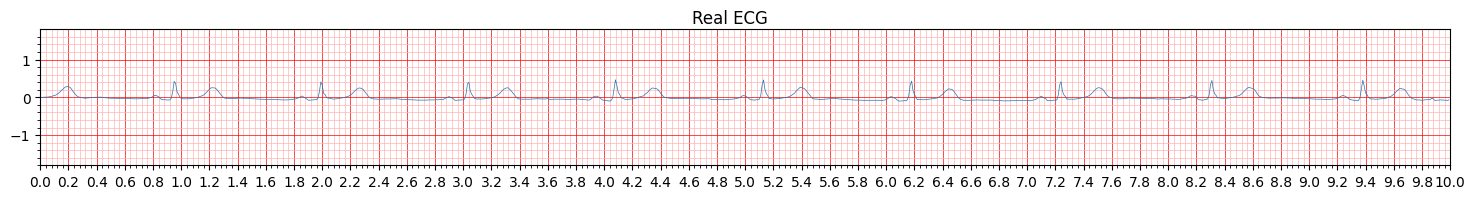

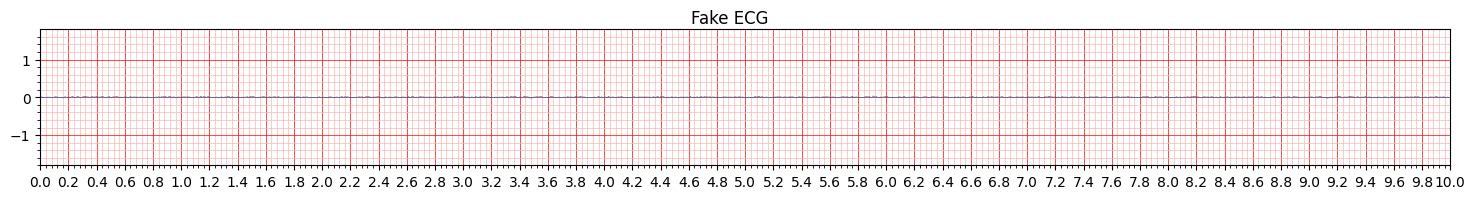

-------------------
epoch 0
epoch 1


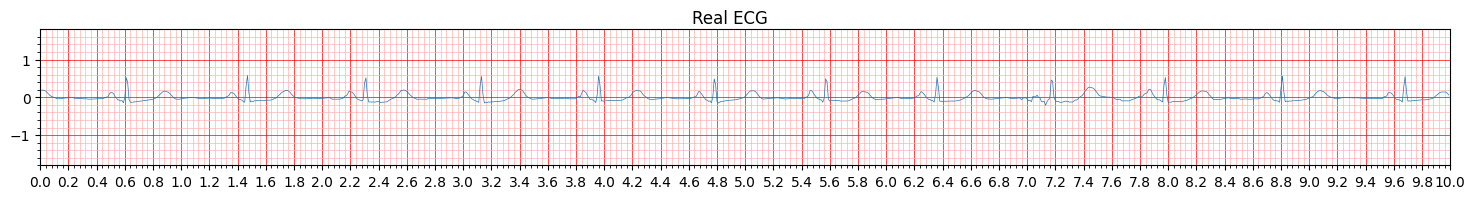

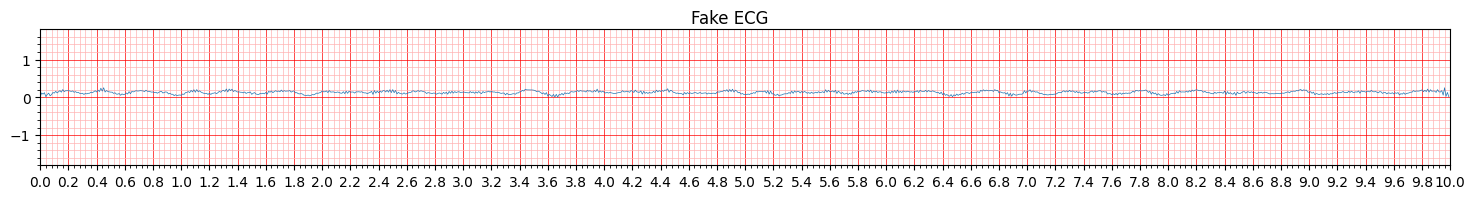

Generator Accuracy: 0.9140625
Generator Mean Loss: 0.75127023
Discriminator Accuracy: 0.5
Discriminator Mean Loss: 0.6329648
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
e

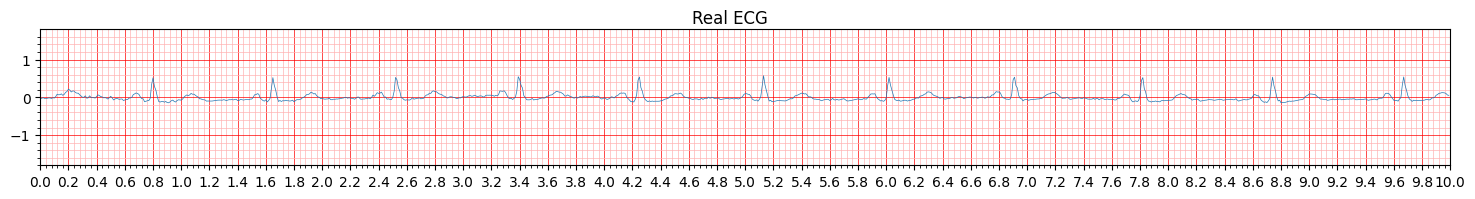

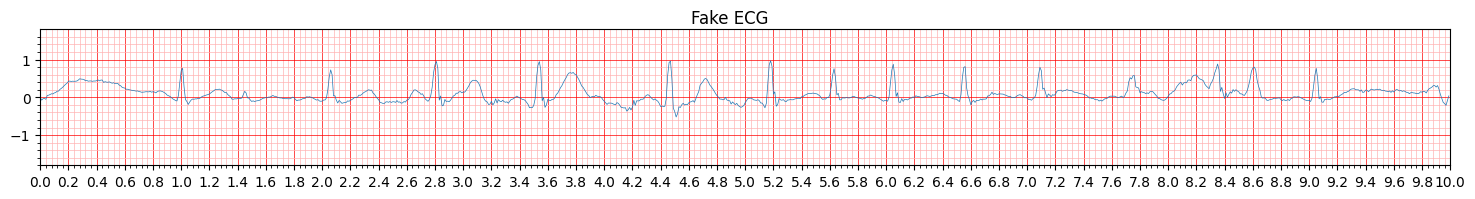

Generator Accuracy: 0.04296875
Generator Mean Loss: 0.69578886
Discriminator Accuracy: 0.5546875
Discriminator Mean Loss: 0.6929393
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 111
epoch 112
epoch 113
epoch 114
epoch 115
epoch 116
epoch 117
epoch 118
epoch 119
epoch 120
epoch 121
epoch 122
epoch 123
epoch 124
epoch 125
epoch 126
epoch 127
epoch 128
epoch 129
epoch 130
epoch 131
epoch 132
epoch 133
epoch 134
epoch 135
epoch 136
epoch 137
epoch 138
epoch 139
epoch 140
epoch 141
epoch 142
epoch 143
epoch 144
epoch 145
epoch 146
epoch 147
epoch 148
epoch 149
epoch 150
epoch 151
epoch 152
epoch 153
epoch 154
epoch 155
epoch 156
epoch 157
epoch 158
epoch 159
epoch 160
epoch 161
epoch 162
epoch 163
epoch 164
epoch 165
epoch 166
epoch 167
epoch 168
epoch 169
epoch 170
epoch 171
epoch 172
epoch 173
epoch 174
epoch 175
epoch 176
epoch 177
epoch 178
epoch 179
epoch 180
epoch 181
epoch 182
epoch 183
epoch 184
epoch 185
epoch 186
epoch 187
epoch 18

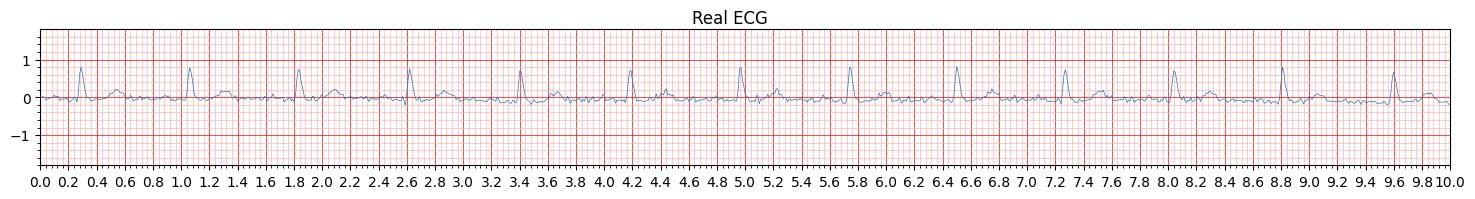

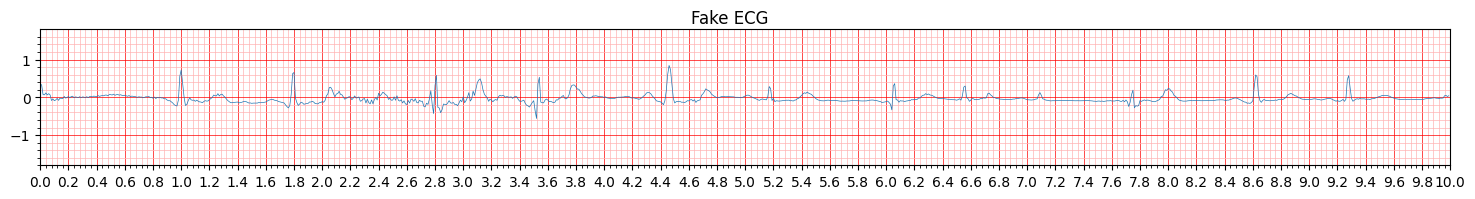

Generator Accuracy: 0.12890625
Generator Mean Loss: 0.695287
Discriminator Accuracy: 0.4921875
Discriminator Mean Loss: 0.6930043
epoch 202
epoch 203
epoch 204
epoch 205
epoch 206
epoch 207
epoch 208
epoch 209
epoch 210
epoch 211
epoch 212
epoch 213
epoch 214
epoch 215
epoch 216
epoch 217
epoch 218
epoch 219
epoch 220
epoch 221
epoch 222
epoch 223
epoch 224
epoch 225
epoch 226
epoch 227
epoch 228
epoch 229
epoch 230
epoch 231
epoch 232
epoch 233
epoch 234
epoch 235
epoch 236
epoch 237
epoch 238
epoch 239
epoch 240
epoch 241
epoch 242
epoch 243
epoch 244
epoch 245
epoch 246
epoch 247
epoch 248
epoch 249


In [40]:
if load_model == False:
# Training hyperparameters
    batch_size = 256
    latent_dim = 12
    steps = len(X_sub) // batch_size
    half_batch = batch_size // 2
    epochs = epoch_amnt

    # Initialize optimizers with initial learning rates for generator and discriminator
    init_lr_disc = 0.001
    init_lr_gen = 0.002
    opt_disc = tf.keras.optimizers.Adam(learning_rate=init_lr_disc, beta_1=0.5, beta_2=0.9)
    opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen, beta_1=0.5, beta_2=0.9)

    # Displaying the initial state before training
    print("Before training:")
    res = gen(generate_latent_points(12, 1))
    compare_real_and_gen_ecg2(res)
    print("-------------------")

    # Training loop
    for epoch in range(epochs):
        # Adjust learning rates every 25 epochs
        if epoch % 50 == True:
            init_lr_disc = init_lr_disc / 2
            init_lr_gen = init_lr_gen / 2
            opt_disc.lr = init_lr_disc
            opt_gen.lr = init_lr_gen
        
        # Lists to store loss values for generator and discriminator for the epoch
        accu_loss_gan = []
        accu_loss_disc = []
        print("epoch {}".format(epoch))
        
        # Training step
        for step in range(steps):
            # Generate real and fake samples
            x_real, y_real = generate_real_samples(X_sub, half_batch)
            x_fake, y_fake = generate_fake_samples(latent_dim, gen, half_batch)
            
            # Combine real and fake samples and shuffle
            X_train = np.vstack([x_real, x_fake])
            y_train = np.vstack([y_real, y_fake])
            p = np.random.permutation(len(y_train))
            
            # Train discriminator
            with tf.GradientTape() as tape:
                # Predict the realness of the shuffled images using the discriminator.
                pred_disc = disc(X_train[p])
                # Calculate loss (Dicrim Performance)
                loss_disc = tf.keras.losses.binary_crossentropy(y_train[p], pred_disc)
            accu_loss_disc.append(loss_disc)
            # Updating the gradient to minimize loss
            grads = tape.gradient(loss_disc, disc.trainable_variables)
            opt_disc.apply_gradients(zip(grads, disc.trainable_variables))
            
            # Train generator
            with tf.GradientTape() as tape:
                x_latent = generate_latent_points(latent_dim, batch_size)
                x_gan = gen(x_latent)
                y_gan = np.ones((batch_size, 1))
                pred_gan = disc(x_gan)
                # We are measuring the Generator's ability to fool the discriminator
                loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
            
            accu_loss_gan.append(loss_gan)
            # Applying new gradient again
            grads = tape.gradient(loss_gan, gen.trainable_variables)
            opt_gen.apply_gradients(zip(grads, gen.trainable_variables))

        # Evaluate and display metrics every 25 epochs
        if epoch % 100 == 1:
            res = gen(generate_latent_points(12, 1))
            compare_real_and_gen_ecg2(res)

            gan_true_labels = np.ones(batch_size) # since we want the discriminator to think they're real
            gan_pred_labels = (np.asarray(pred_gan).ravel() > 0.5).astype(int) # convert probabilities to class labels using 0.5 threshold
            gen_accuracy = accuracy_score(gan_true_labels, gan_pred_labels)

            disc_true_labels = y_train.ravel() # real ECGs have label 1, fake ones have label 0
            disc_pred_labels = (np.asarray(pred_disc).ravel() > 0.5).astype(int) # convert probabilities to class labels using 0.5 threshold
            disc_accuracy = accuracy_score(disc_true_labels, disc_pred_labels)

            print("Generator Accuracy:", gen_accuracy)
            print("Generator Mean Loss:", np.mean(np.asarray(accu_loss_gan)))
            print("Discriminator Accuracy:", disc_accuracy)
            print("Discriminator Mean Loss:", np.mean(np.asarray(accu_loss_disc)))



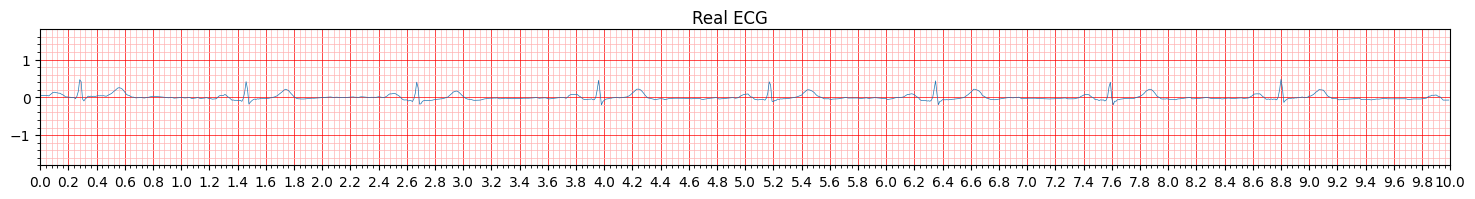

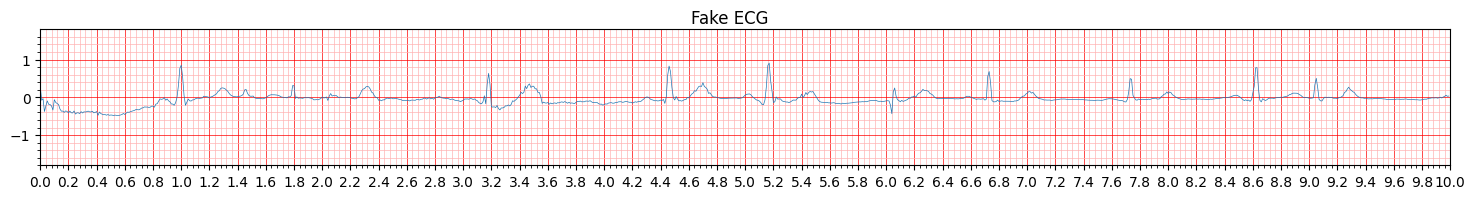

In [41]:
res = gen(generate_latent_points(12, 1))
compare_real_and_gen_ecg2(res)

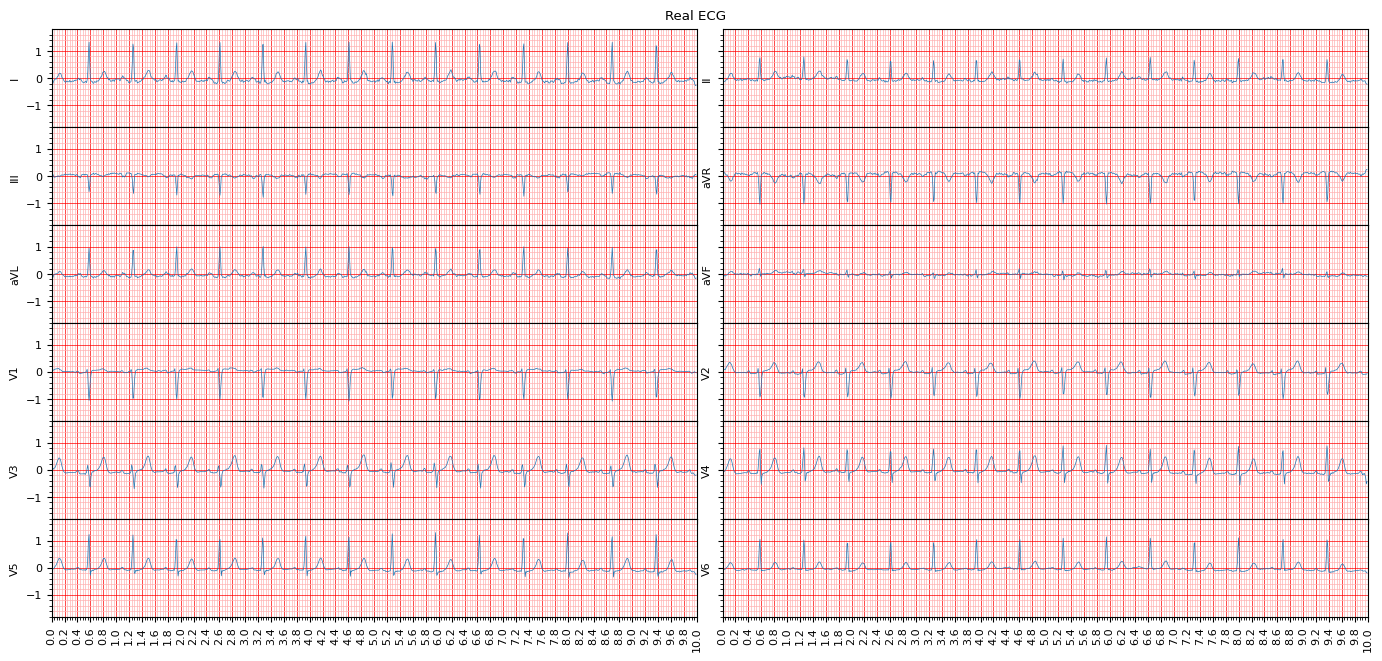

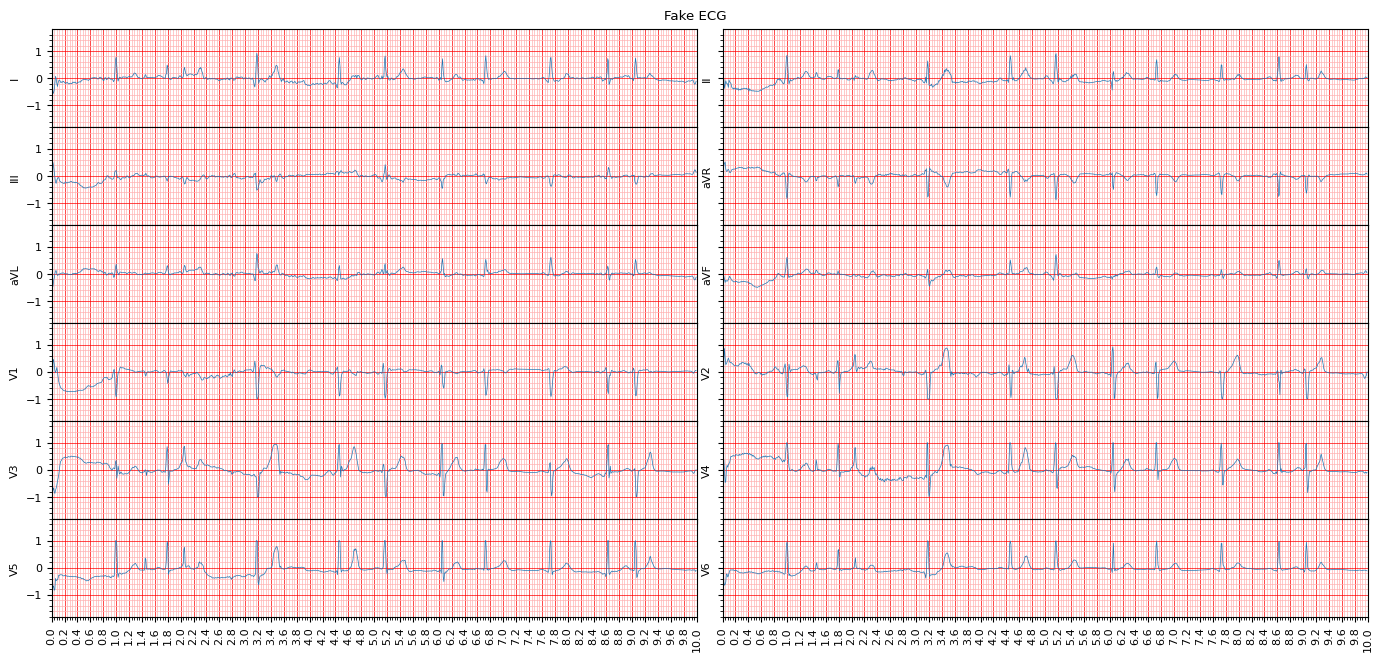

In [42]:
compare_real_and_gen_ecg_12(res)

In [43]:
if(save_model):
    gen.save_weights(f"../saved_models/gans/generators/[{age_range[0]}-{age_range[1]}]_generator_weights.h5")
    tf.keras.models.save_model(gen, f'../saved_models/gans/generators/[{age_range[0]}-{age_range[1]}]-{age_range[1]}_generator_model')
    disc.save_weights(f"../saved_models/gans/discriminators/[{age_range[0]}-{age_range[1]}]_discriminator_weights.h5")
    tf.keras.models.save_model(disc, f'../saved_models/gans/discriminators/[{age_range[0]}-{age_range[1]}]_discrminator_model')

INFO:tensorflow:Assets written to: ../saved_models/gans/generators/[50-75]-75_generator_model\assets


INFO:tensorflow:Assets written to: ../saved_models/gans/generators/[50-75]-75_generator_model\assets


INFO:tensorflow:Assets written to: ../saved_models/gans/discriminators/[50-75]_discrminator_model\assets


INFO:tensorflow:Assets written to: ../saved_models/gans/discriminators/[50-75]_discrminator_model\assets


In [44]:
if(load_model):
    disc = tf.keras.models.load_model('../saved_models/gans/discrminator_model')
    gen = tf.keras.models.load_model('../saved_models/gans/generator_model')

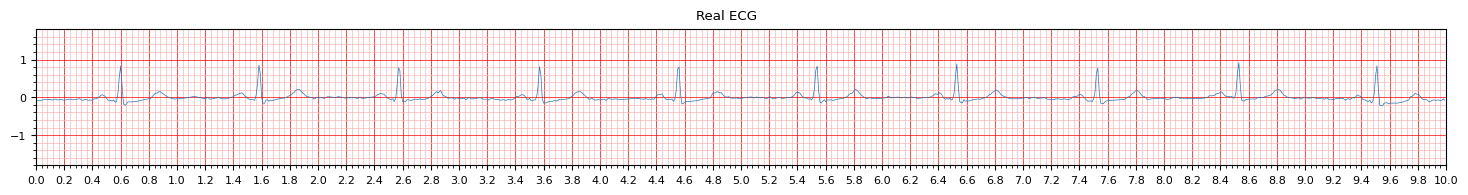

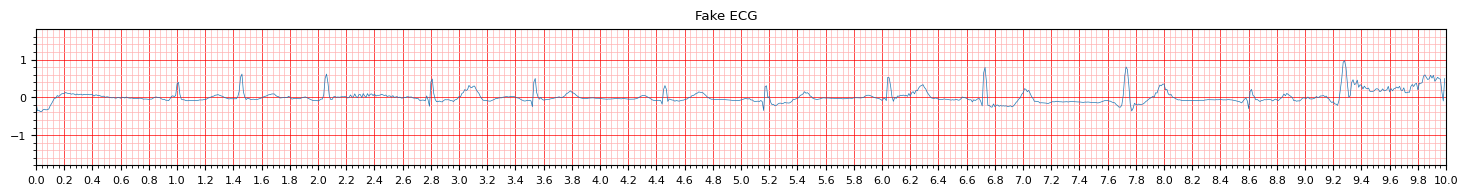

In [45]:
res = gen(generate_latent_points(12, 1))
compare_real_and_gen_ecg2(res)

In [46]:
with tf.device('/CPU:0'):
    # Generate latent points for 100 ECG signals
    latent_points = generate_latent_points(12, gen_amnt)

    # Generate ECG signals for the entire batch
    generated_ecg_signals_batch = gen(latent_points).numpy()

    # Save the generated signals
    np.save(f'../data/fake_ecgs/{gen_amnt}_{input_amnt}_[{age_range[0]}-{age_range[1]}]_generated_ecg_signals.npy', generated_ecg_signals_batch)  # Saving as .npy file